# Feature: attenuation correction (`removeRange`)

This notebook covers the development of a method to determine (and correct for) an attenuation/absorption in DIDSON data.

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob 
from skimage.io import imread 

In [2]:
# test_image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/synth/dataset-1/*raw.png') 
test_image_list = glob('../data/dataset-1/*raw.png') # raw images only
print 'Test set size:',len(test_image_list)

# two sets of images observing open water (no objects) with window range from 2.25 to 11.25m (9m window)
bg_image_list_1 = glob('../data/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print 'Background set 1 size:', len(bg_image_list_1)
bg_image_list_2 = glob('../data/dataset-3/*raw.png') # 
print 'Background set 2 size:',len(bg_image_list_2)

Test set size: 10
Background set 1 size: 116
Background set 2 size: 270


In [3]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
# print 'Beams:',didson.num_beams
# print 'Range bins:',didson.num_bins
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise

Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.0199794887389 , y: 0.01998400879
Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002


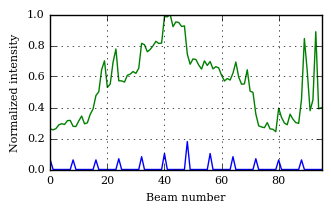

In [4]:
psf = didson.psf[0,:]
plt.figure(figsize=(3.5,2))
plt.plot(psf)
plt.plot(didson.taper)
plt.grid()
plt.xlabel('Beam number')
plt.ylabel('Normalized intensity')
plt.rc('font', size=8)
plt.xlim([0, 95])
plt.savefig('didson_psf_taper.eps',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.05)
plt.show()

## Attenuation correction

This function corrects for beampattern-related effects and then computes the average intensity vs rane

In [163]:
def compile(image_list, sonar,enhance=False):
    N = len(image_list)
    data = imread(image_list[0],as_grey=True).astype(np.float64) # 0-255.0
    for i in range(1,N):
        ping = imread(image_list[i],as_grey=True).astype(np.float64) # 0-255.0
        if(enhance):
            ping = sonar.deconvolve(ping)
            ping = sonar.removeTaper(ping)
        data = np.hstack((data,ping))   
#         att = np.sum(ping, axis = 1)
#         att/=(att.max()+0.0) # renormalization
#         attenuation += att
#     attenuation/=(N+0.0)
#     attenuation/=np.amax(attenuation)

    data/=255.0
    return data

def processMV(image_list, sonar,enhance=False):
    ds = compile(image_list,sonar,enhance)
    print ds.shape
    print ds.min(), ds.max()
    m = np.zeros(512)
    v = np.zeros(512)
    for i in range(0,512):
        m[i] = np.mean(ds1[i,:])
        v[i] = np.var(ds1[i,:])
    return (m,v)

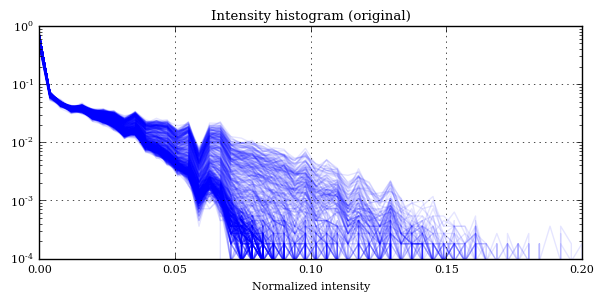

In [118]:
ds1 = compile(bg_image_list_1, didson)
bins = np.linspace(0,1,256)
plt.figure(figsize=(7,3))
for i in range(0,512):
    hi = np.histogram(ds1[i,:],bins)
    plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),'-b',alpha=0.1)
    
plt.yscale('log')
plt.grid()
plt.xlim([0,0.2])
# plt.xlim([0,10])
plt.ylim([1e-4,1])
plt.xlabel('Normalized intensity')
plt.title('Intensity histogram (original)')

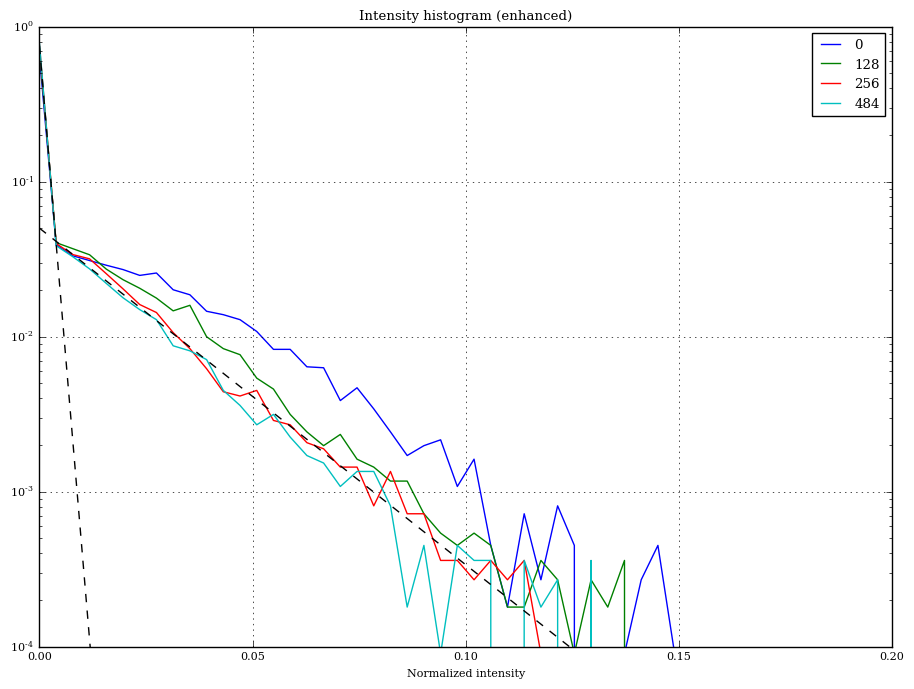

In [161]:
ds1 = compile(bg_image_list_1, didson,True)
bins = np.linspace(0,1,256)
plt.figure(figsize=(11,8))
for i in range(0,512,128):
    hi = np.histogram(ds1[i,:],bins)
#     uncomment this line to get an overview
#     plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),'-r',alpha=0.5)
#     uncomment this line to see particular range values
    plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0))
plt.legend(('0','128','256','484'))    
l_bg = 50
plt.plot(bins[:-1],0.001*l_bg*np.exp(-l_bg*bins[:-1]),'--k')

l_n = 750
plt.plot(bins[:-1],0.001*l_n*np.exp(-l_n*bins[:-1]),'--k')
plt.yscale('log')
plt.grid()
plt.xlim([0,0.2])
# plt.xlim([0,10])
plt.ylim([1e-4,1])
plt.xlabel('Normalized intensity')
plt.title('Intensity histogram (enhanced)');


In [164]:
(m1,v1) = processMV(bg_image_list_1, didson,True)
(m2,v2) = processMV(bg_image_list_2, didson,True)


(512, 11136)
0.0 0.254901960784
(512, 25920)
0.0 0.313725490196


(2.25, 11.25)

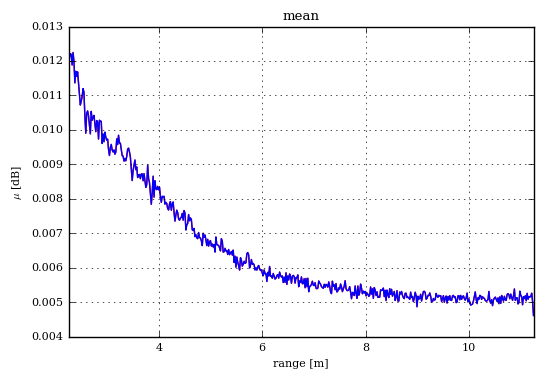

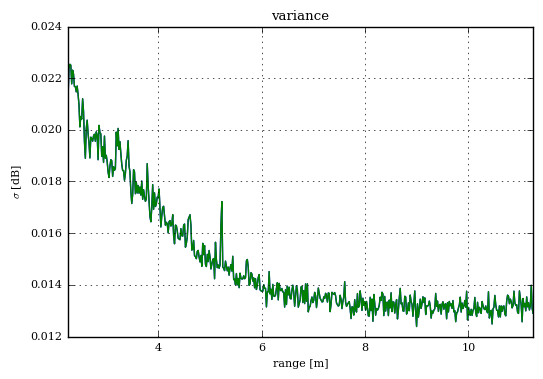

In [167]:
r = np.linspace(2.25, 11.25, 512)

plt.figure()
plt.plot(r,m1,c='r')
plt.plot(r,m2,c='b')
plt.xlabel('range [m]')
plt.ylabel('$\mu$ [dB]')
plt.title('mean')
plt.grid()
plt.xlim([2.25,11.25])

plt.figure()
plt.plot(r,np.sqrt(v1))
plt.plot(r,np.sqrt(v2))
plt.xlabel('range [m]')
plt.ylabel('$\sigma$ [dB]')
plt.title('variance')
plt.grid()
plt.xlim([2.25,11.25])

Data set 1 model parameters:
SL: -81.12331191
beta -2.43474378291
gain -0.000469840047149
offset -0.0204873143943


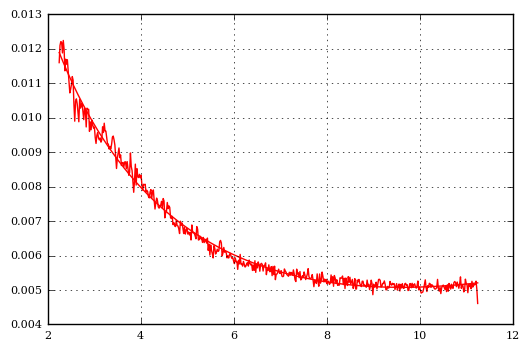

In [171]:
from scipy.optimize import curve_fit

def sonareq(r, sl,beta,gain,offset):
    
    return gain*(sl - 2*(10*np.log10(r**beta) + 1.1*r)) + offset 

p, v = curve_fit(sonareq, r, m1, p0=[1.0, 1.0, 1.0,1.0])
print 'Data set 1 model parameters:'
print 'SL:',p[0]
print 'beta', p[1]
print 'gain', p[2]
print 'offset', p[3]


m_est = sonareq(r,p[0],p[1],p[2],p[3])
plt.plot(r,m1,c='r')
plt.plot(r,m_est,c='r')
plt.grid()

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
at1 = computeRL(bg_image_list_1, didson)
# at2 = computeAttenuation(bg_image_list_2, didson)

bin_length = (didson.max_range - didson.min_range)/didson.num_bins
r = didson.min_range + bin_length*np.arange(0, didson.num_bins)

plt.figure()
plt.plot(r,at1)
# plt.plot(r,at2)
plt.ylim([0,1])
# plt.xscale('log')
# plt.yscale('log')

plt.grid(b=True, which='both')
# plt.grid(b=True, which='major',linestyle='-')
# plt.grid(b=True, which='minor',linestyle='--')
plt.xlim([didson.min_range, didson.max_range])
plt.xlabel('Range [m]')


In [ ]:
def attenuation(r, a, b, c ,d):
    return 2*a*(10*np.log10(r**b) + 1.1*r) + d # spreading model (need to add absorption losses)
#     return a*np.exp(-r) + b # negative exponential
#     return a/(r**b) + c # 
#     return a*np.exp(-b*r)/(r**c)
#     return a/(r-b)**c

xdata = 2.25 + (9.0/512)*np.arange(0,512)
print xdata.shape
ydata = np.squeeze(at1)
print ydata.shape

p, v = curve_fit(attenuation, xdata, np.squeeze(at1), p0=[1, 1,1.0, 0])
print 'Test set 1 - model parameters:',p[0], p[1], p[2], p[3]

at_est = attenuation(xdata, p[0], p[1], p[2], p[3])

plt.plot(xdata, np.squeeze(at1))
plt.plot(xdata, at_est)

p, v = curve_fit(attenuation, xdata, np.squeeze(at2), p0=[1,1,1,0])
print 'Test set 2 - model parameters:', p[0], p[1], p[2], p[3]

at_est = attenuation(xdata, p[0], p[1], p[2], p[3])

plt.plot(xdata, np.squeeze(at2))
plt.plot(xdata, at_est)
plt.ylim([0,1])
plt.grid(b=True, which='both')
plt.xlabel('Range [m]')
plt.ylabel('Intensity (normalized)')
plt.legend(['Test set 1','Test set 1 - model','Test set 2', 'Test set 2 - model'])
plt.savefig("range.png",transparent=True,pad_inches=0.0)

In [ ]:
tl = 2*(10*np.log10(2.25**2)+1.1*2.25)
# tl*1.0/90.0
print tl,'dB'

In [ ]:
def removeAttenuation(ping, attenuation):
    attenuation.shape = (len(attenuation),1)
    att = np.tile(attenuation, (1,ping.shape[1]))
    ping2 = ping.astype(np.float64)
    ping2/=att
    ping2*=((ping.max()+0.0)/ping2.max())
    return ping2

In [ ]:
def computeHist(ping):
    bins = np.arange(0,256)
    
    h = np.histogram(ping, bins)
       
    return (bins, (h[0]+0.0)/np.sum(h[0])) 

In [ ]:
# image_list = bg_image_list_1
image_list = test_image_list

idx = np.random.randint(0,len(image_list))
# idx = 8
print idx

ping0 = imread(image_list[idx],as_grey=True)
print ping0.min(), ping0.max()
(b, h0) = computeHist(ping0)

ping1 = didson.deconvolve(ping0)
print ping1.min(), ping1.max()
(b, h1) = computeHist(ping1)

ping2 = didson.removeTaper(ping1)
print ping2.min(), ping2.max()
(b, h2) = computeHist(ping2)

ping3 = removeAttenuation(ping2, at_est)
print ping3.min(), ping3.max()
(b, h3) = computeHist(ping3)

didson.resetWindow(2.25,11.25,0.01)

colormap = 'gray'
# colormap = 'jet'

plt.figure(figsize=(20,8))
plt.subplot(4,1,1)
ping0c=didson.toCart(ping0,width=320,bg=255.0)
plt.imshow(ping0c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('original')
plt.axis('off')
plt.subplot(4,1,2)

plt.imshow(ping0c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution')
plt.axis('off')
plt.subplot(4,1,3)
ping2c = didson.toCart(ping2,width=320,bg=255.0)
plt.imshow(ping2c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution, taper removal')
plt.axis('off')
plt.subplot(4,1,4)
ping3c = didson.toCart(ping3,width=320,bg=255.0)
plt.imshow(ping3c.transpose(),vmin=0,vmax=255,cmap=colormap)
plt.title('deconvolution, taper removal, att. comp.')
plt.axis('off')


plt.figure(figsize=(2*8,8))
plt.plot(b[:-1],h0)

plt.plot(b[:-1],h1)
plt.plot(b[:-1],h2)
plt.plot(b[:-1],h3)
plt.yscale('log')
plt.grid(b=True, which='both')
plt.xlim([0,255])
plt.ylim([1e-6,1e0])
plt.legend(('0','1','2','3'))

from scipy import stats
plt.plot(b[:-1], stats.expon.pdf(b[:-1], loc=0,scale=5),color='k' )

print ping1.shape